# Matrix Computations of Quantum Gates

*Andy Dolan*

In this notebook, we'll run through an example of applying a quantum circuit to a 2-qubit system. We'll first calculate the resulting probability vector of the measured qubits by hand, and then leverage the qiskit library to demonstrate a simulated example. The circuit that we'll be demonstrating is illustrated in the following diagram:

![](./images/Circuit.png)

This circuit first applies a Hadamard gate $H$ to the first qubit (`q[0]`; $q_0$). A $CNOT$ gate is then applied, where the first qubit acts as the control, and the second qubit acts as the target.

This circuit is a simple exmaple of creating an entangled pair; $q_0$ is first brought into a superposition via the $H$ gate, the $CNOT$ gate creates a Bell state, and the measurements of $q_0$ and $q_1$ are correlated, despite only $q_0$ being brought into a superposition state.

In this notebook, we will compute the probability vector of the final measured state of the 2-qubit system.

## Manual Computation

To begin, we'll leverage matrices to compute the probability vector of this circuit.

In [1]:
import numpy as np

## Setup

First we'll define:

* Our qubits (a 2 qubit register, represented as probability vectors, each initialized to `|0>`)
* A few gates ($H$, $CNOT$)

In [2]:
# "Qubits"
q = [np.array([[1], [0]]) for i in range(2)]
q

[array([[1],
        [0]]),
 array([[1],
        [0]])]

In [3]:
# Gates: CNOT, H, I
cnot = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

h = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])

identity = np.array([[1, 0], [0, 1]])

print('CNOT:\n{}'.format(cnot))
print('H:\n{}'.format(h))
print('I:\n{}'.format(identity))

CNOT:
[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]
H:
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
I:
[[1 0]
 [0 1]]


Finally, we can represent the combined state of the 2-qubit "system" with the tensor product of the individual states:

In [4]:
combined_state_vector = np.kron(q[0], q[1])
combined_state_vector

array([[1],
       [0],
       [0],
       [0]])

Which corresponds to the state `|00>`

## Computing the Circuit's Unitary Matrix

The Unitary matrix representation of our simple circuit is computed as follows:

$$
\begin{align}
U &= CNOT\ (H \otimes I)\\[1em]
&=
\begin{pmatrix}
    1 & 0 & 0 & 0\\
    0 & 1 & 0 & 0\\
    0 & 0 & 0 & 1\\
    0 & 0 & 1 & 0
\end{pmatrix}
\left(\frac{1}{\sqrt{2}}
\begin{pmatrix}
    1 & 1\\
    1 & -1
\end{pmatrix} \otimes
\begin{pmatrix}
    1 & 0\\
    0 & 1
\end{pmatrix}\right)\\[1em]
&= \frac{1}{\sqrt{2}}
\begin{pmatrix}
    1 & 0 & 0 & 0\\
    0 & 1 & 0 & 0\\
    0 & 0 & 0 & 1\\
    0 & 0 & 1 & 0
\end{pmatrix}
\begin{pmatrix}
    1 & 0 & 1 & 0\\
    0 & 1 & 0 & 1\\
    1 & 0 & -1 & 0\\
    0 & 1 & 0 & -1
\end{pmatrix}\\[1em]
&= \frac{1}{\sqrt{2}}
\begin{pmatrix}
    1 & 0 & 1 & 0\\
    0 & 1 & 0 & 1\\
    0 & 1 & 0 & -1\\
    1 & 0 & -1 & 0
\end{pmatrix}
\end{align}
$$

A few interesting questions about this calculation:

* Why do we need the identity matrix $I$ in the mix?
  * The Hadamard gate $H$ acts on only the first qubit; however, because the $CNOT$ gate acts on both, the dimensionality of the computation changes to a 4x4 matrix. We use $I$ to "apply" the $H$ gate step to both qubits, such that the state of the second qubit isn't changed by that step in the operation. We achieve this using a Kronecker product $(\otimes)$, and the resulting matrix is of dimension 4x4.
* Why does $CNOT$ come before the other gates in this computation?
  * Recall that the gates act on the qubits in sequence - first the $H$ gate acts on the first qubit, then the CNOT gate acts on the *result* of that step (on both qubits).

We can compute this unitary matrix $U$ representation with the code below.

In [5]:
u = cnot @ np.kron(h, identity)
u

array([[ 0.70710678,  0.        ,  0.70710678,  0.        ],
       [ 0.        ,  0.70710678,  0.        ,  0.70710678],
       [ 0.        ,  0.70710678,  0.        , -0.70710678],
       [ 0.70710678,  0.        , -0.70710678,  0.        ]])

We then apply this matrix representation to our combined state vector to see the resultant probabilities of the 4 different states after measurement:

In [6]:
u @ combined_state_vector

array([[0.70710678],
       [0.        ],
       [0.        ],
       [0.70710678]])

As a result, we see the resultant probability vector as

$$
\begin{bmatrix}
    \frac{1}{\sqrt{2}}\\
    0\\
    0\\
    \frac{1}{\sqrt{2}}
\end{bmatrix}
$$

Recall that these probabilities correspond according to the following table:

| Qubit state | Probability vector | Corresponding Probability |
| ----------- | ------------------ | ------------------------- |
| `\|00>`     | Index 0 (topmost)  | $(\frac{1}{\sqrt{2}})^2 = \frac{1}{2}$ |
| `\|01>`     | Index 1            | $0$                       |
| `\|10>`     | Index 2            | $0$                       |
| `\|11>`     | Index 3 (bottom)   | $(\frac{1}{\sqrt{2}})^2 = \frac{1}{2}$ |

Thus, it can be said that this circuit results in a 50% chance of measurement resulting in the `|00>` state, and a 50% chance of measurement resulting in the `|11>` state, thanks to the entangled pair created through the use of the $H$ and $CNOT$ gates in sequence.

## Leveraging Qiskit to Simulate the Circuit

Now that we've done the math, let's build the circuit and run it on a simulated quantum computer. We'll leverage the qiskit library to achieve this.

In [7]:
from qiskit import QuantumCircuit, Aer, transpile, quantum_info as qi
from qiskit.visualization import plot_histogram

First we'll build the circuit, then we'll execute it on a number of different backends provided by qiskit.

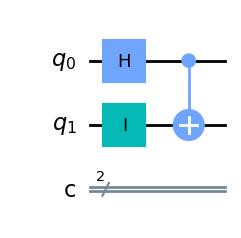

In [8]:
circuit = QuantumCircuit(2,2)

circuit.h(0)
circuit.i(1)
circuit.cx(0, 1)

circuit.draw('mpl')

Note that, for the first example, we do not perform measurement on the qubits.

Qiskit stores qubits in Little-Endian fashion; for our understanding, we'll use qiskit to compute the unitary matrix of our circuit using the `reverse_bits` method.

In [9]:
np.real(qi.Operator(circuit.reverse_bits()))

array([[ 0.70710678,  0.        ,  0.70710678,  0.        ],
       [ 0.        ,  0.70710678,  0.        ,  0.70710678],
       [ 0.        ,  0.70710678,  0.        , -0.70710678],
       [ 0.70710678,  0.        , -0.70710678,  0.        ]])

Here we see that this output is the same as our manual computation of the unitary matrix $U$ above!

### Simulator Backend

Now we'll use a simulator provided by qiskit to see the corresponding probability vector in action. We'll need to add measuremnets to our circuit first:

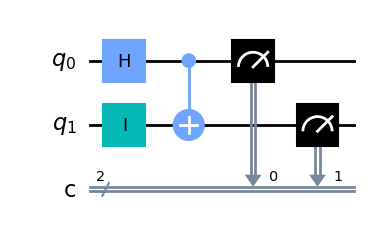

In [10]:
circuit.measure([0, 1], [0, 1])
circuit.draw('mpl')

Now we'll run the circuit 1,024 times and see which states we get back.

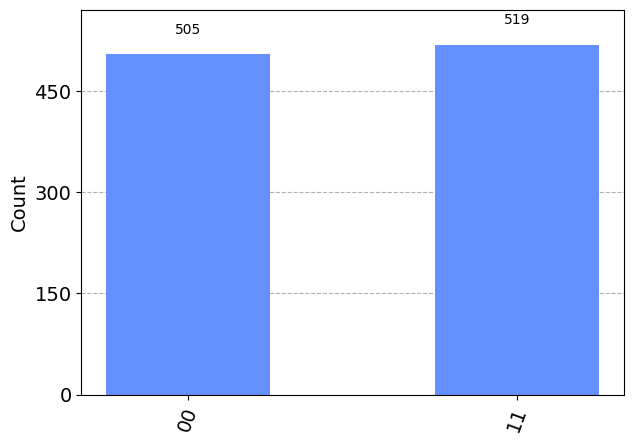

In [11]:
sim_backend = Aer.get_backend('qasm_simulator')

job = sim_backend.run(transpile(circuit, sim_backend), shots=1024)
result = job.result()

counts = result.get_counts()

plot_histogram(counts)

As expected from our earlier computations, we *only* get back the `|00>` and `|11>` states, each about 50% of the time!